# Laboratorium 1


## Konfiguracja


In [2]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

## Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)


In [3]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
        

## Rozwiązanie

### 1. Przygotuj następujące zbiory punktów (2D, współrzędne rzeczywiste typu double):

#### a) 10^5 losowych punktów o współrzędnych z przedziału [-1000, 1000]

In [4]:
import random 
import math
from random import randint

<IPython.core.display.Javascript object>


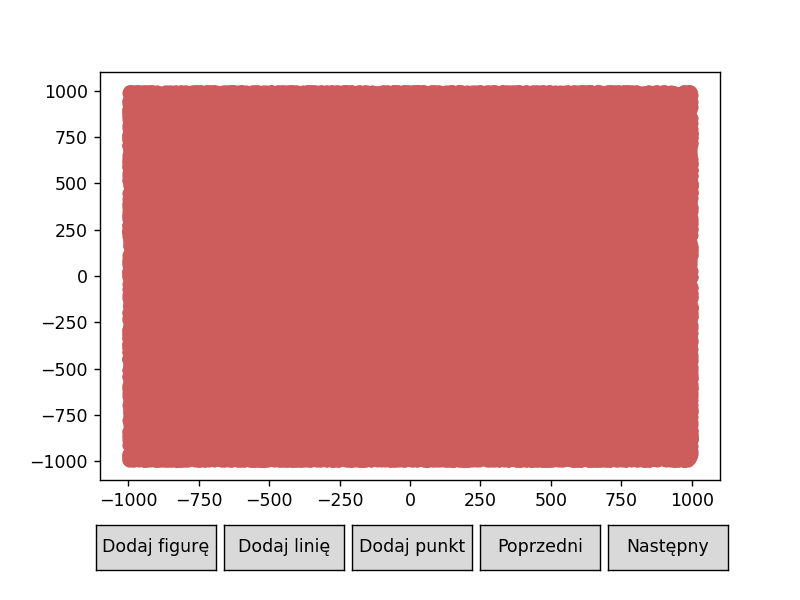

In [90]:
%matplotlib notebook
points1=[(randint(-1000,1000),randint(-1000,1000)) for i in range (10**5)]
plot = Plot(points=[PointsCollection(points1,color='indianred')])
plot.draw()

#### b) 10^5 losowych punktów o współrzędnych z przedziału [-10^14, 10^14]

<IPython.core.display.Javascript object>


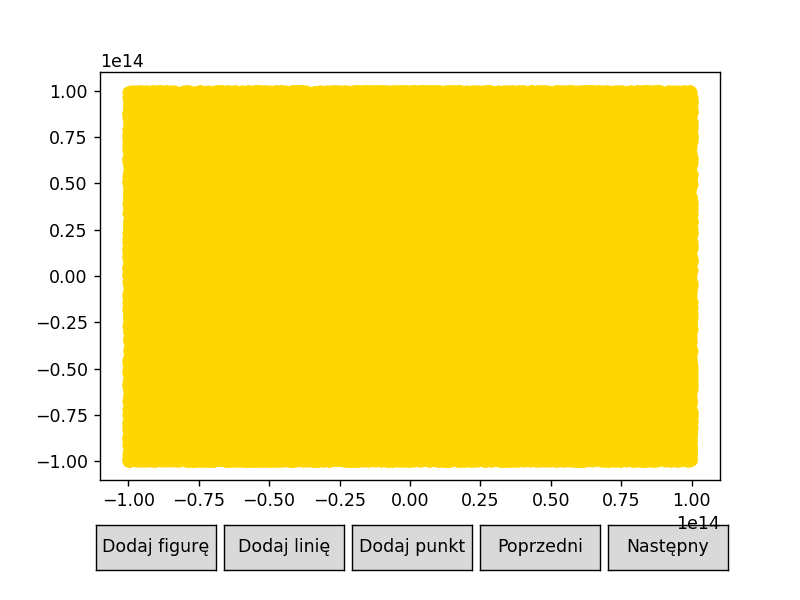

In [91]:
%matplotlib notebook
points2=[(randint(-10**14,10**14),randint(-10**14,10**14)) for i in range (10**5)]
plot = Plot(points=[PointsCollection(points2,color='gold')])
plot.draw()

#### c) 1000 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100

In [1]:
%matplotlib notebook
R=100
points3=[]
for i in range (1000):
    t=2*math.pi*random.random()
    points3.append((R*math.sin(t),R*math.cos(t)))
    
plot = Plot(points=[PointsCollection(points3,
color='powderblue')])

plot.draw()

NameError: name 'math' is not defined

#### d) 1000 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej wyznaczonej przez wektor (a, b) 
#### przyjmij a = [-1.0, 0.0], b = [1.0, 0.1]

<IPython.core.display.Javascript object>


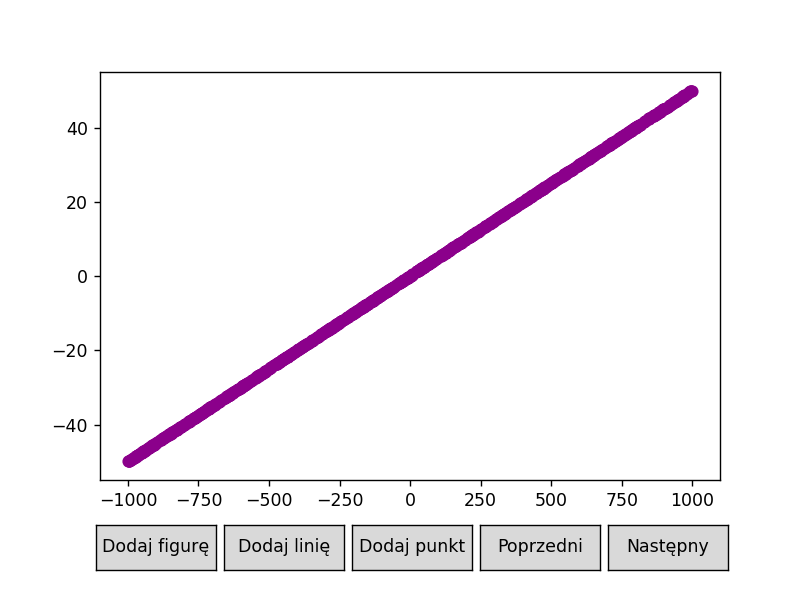

In [93]:
%matplotlib notebook
points4=[]
a=[-1.0,0.0]
b=[1.0,0.1]
for i in range (1000):
    x=randint(-1000,1000)
    y=((b[1]-a[1])*x/(b[0]-a[0])+a[1]-a[0]*(b[1]-a[1])/(b[0]-a[0]))
    points4.append((x,y))
    
plot = Plot(points=[PointsCollection(points4,
color='darkmagenta')])

plot.draw()

#### Samodzielna implementacja wyznacznika 3x3 i 2x2

In [94]:
def det3x3(a,b,p):
    return (a[0]*b[1]+a[1]*p[0]+b[0]*p[1]-p[0]*b[1]-a[1]*b[0]-a[0]*p[1])

In [95]:
def det2x2(a,b,p):
    return (a[0]-p[0])*(b[1]-p[1])-(a[1]-p[1])*(b[0]-p[0])

#### Podział punktów względem ich orientacji w stosunku do odcinka ab

In [96]:
def classify_points(points,det,a,b,tolerance,precision):
    cl = { 'l':[],'r':[], 'c':[]}

    for p in points:
        if precision!=0:
            d = np.round(det(a,b,p),precision)
        else:
            d=det(a,b,p)
        if(d < -tolerance):
            cl['l'].append(p)
        elif(d>tolerance):
            cl['r'].append(p)
        else:
            cl['c'].append(p)
    return cl


def pr_points(points, det, a,b,tolerance,precision):
    cl = classify_points(points,det,a,b,tolerance,precision)
    plot = Plot(points=[PointsCollection(cl['l'],color='blue'),PointsCollection(cl['r'], color = 'red'),
          PointsCollection(cl['c'], color = 'green')])
    plot.draw()
    print("Po lewej: ",len(cl['l']))
    print("Po prawej: ",len(cl['r']))
    print("Współliniowe: ",len(cl['c']))
a = [-1.0, 0.0]
b = [1.0, 0.1]
tol=10**(-14)
prec=0

<IPython.core.display.Javascript object>


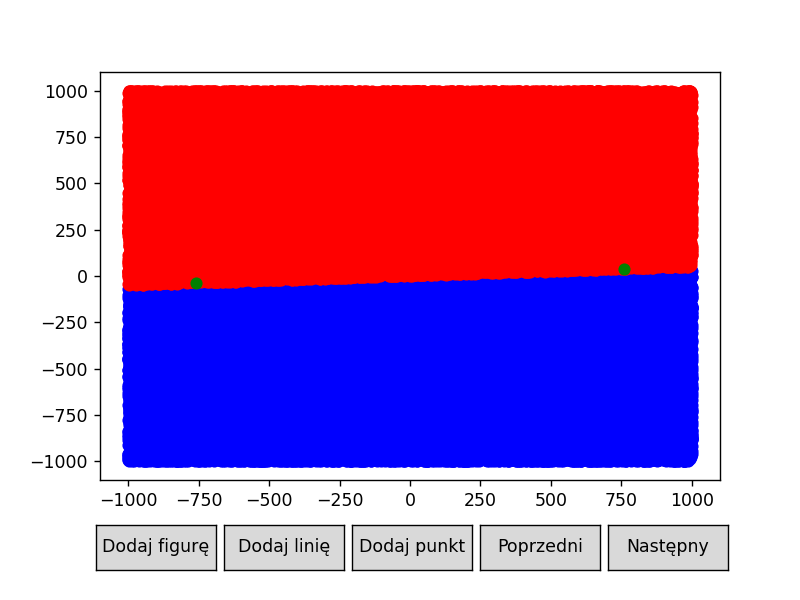

Po lewej:  50203
Po prawej:  49795
Współliniowe:  2


In [97]:
%matplotlib notebook

pr_points(points1,det3x3,a,b,tol,prec)

<IPython.core.display.Javascript object>


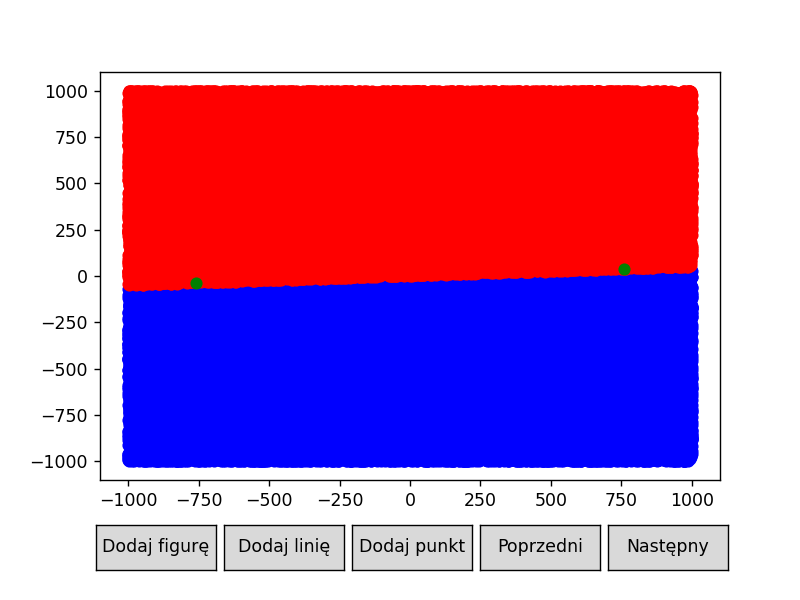

Po lewej:  50203
Po prawej:  49795
Współliniowe:  2


In [98]:
%matplotlib notebook

pr_points(points1,det2x2,a,b,tol,prec)

<IPython.core.display.Javascript object>


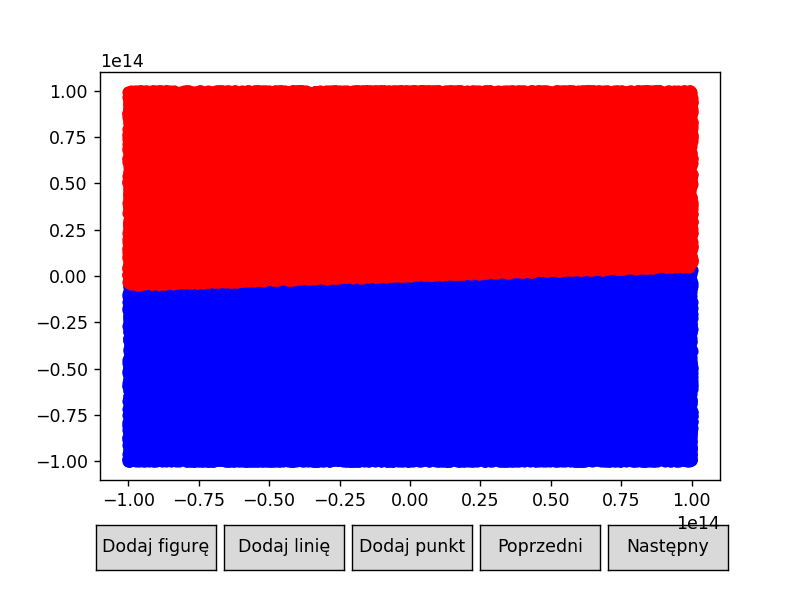

Po lewej:  50128
Po prawej:  49872
Współliniowe:  0


In [99]:
pr_points(points2,det3x3,a,b,tol,prec)

<IPython.core.display.Javascript object>


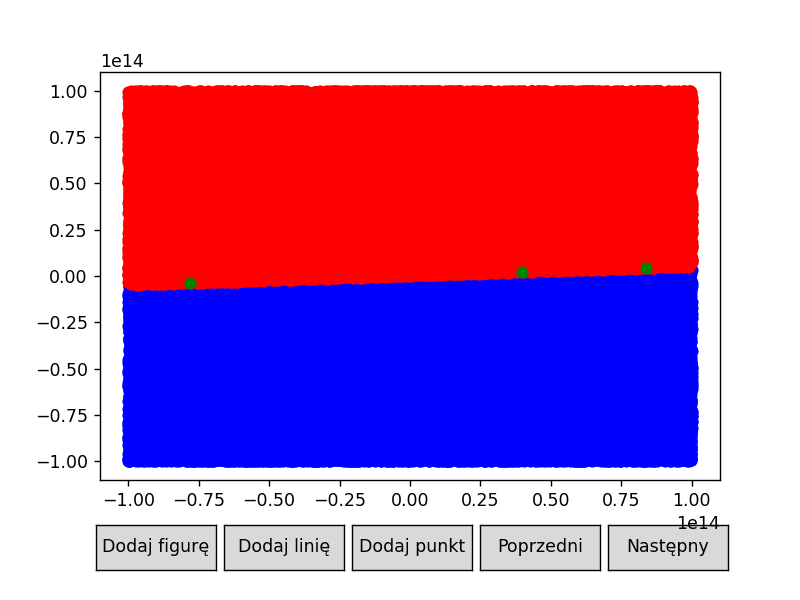

Po lewej:  50127
Po prawej:  49870
Współliniowe:  3


In [100]:
pr_points(points2,det2x2,a,b,tol,prec)

<IPython.core.display.Javascript object>


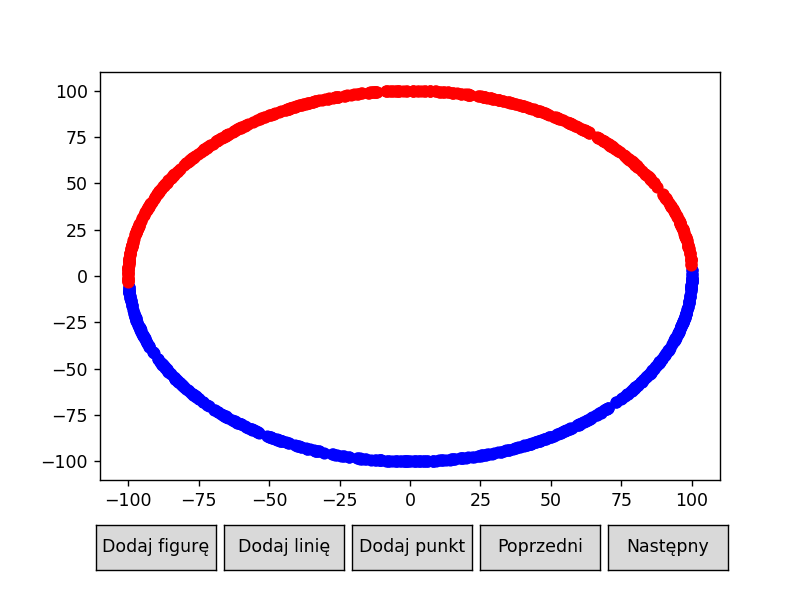

Po lewej:  495
Po prawej:  505
Współliniowe:  0


In [101]:
pr_points(points3,det3x3,a,b,tol,prec)

<IPython.core.display.Javascript object>


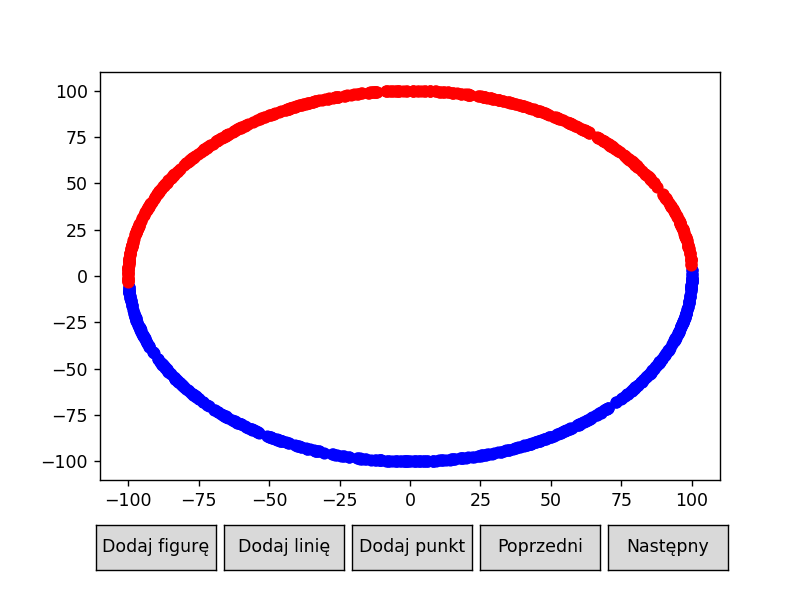

Po lewej:  495
Po prawej:  505
Współliniowe:  0


In [102]:
pr_points(points3,det2x2,a,b,tol,prec)

<IPython.core.display.Javascript object>


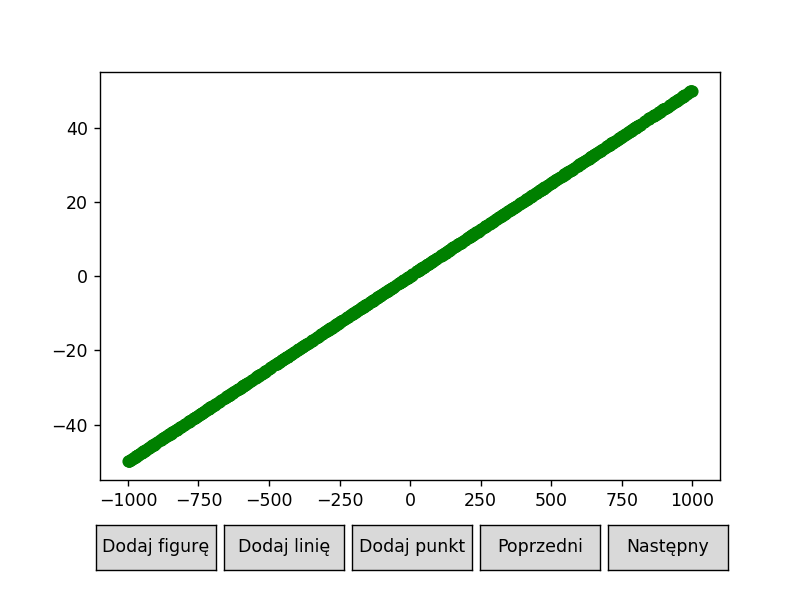

Po lewej:  0
Po prawej:  0
Współliniowe:  1000


In [103]:
pr_points(points4,det3x3,a,b,tol,prec)

<IPython.core.display.Javascript object>


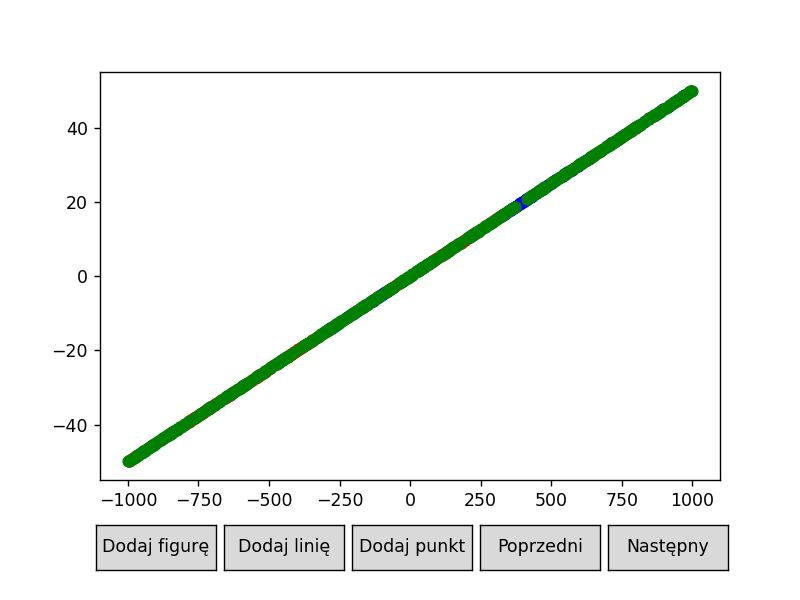

Po lewej:  137
Po prawej:  151
Współliniowe:  712


In [104]:
pr_points(points4,det2x2,a,b,tol,prec)

#### Biblioteczne procedury obliczania wyznacznika 3x3 i 2x2

In [105]:
def det1_3x3(a,b,p):
    arr = np.array([[a[0],a[1],1],[b[0],b[1],1],[p[0],p[1],1]])
    return np.linalg.det(arr)

In [106]:
def det1_2x2(a,b,p):
    arr = np.array([[a[0]-p[0], a[1]-p[1]],[b[0]-p[0], b[1]-p[1]]])
    return np.linalg.det(arr)

<IPython.core.display.Javascript object>


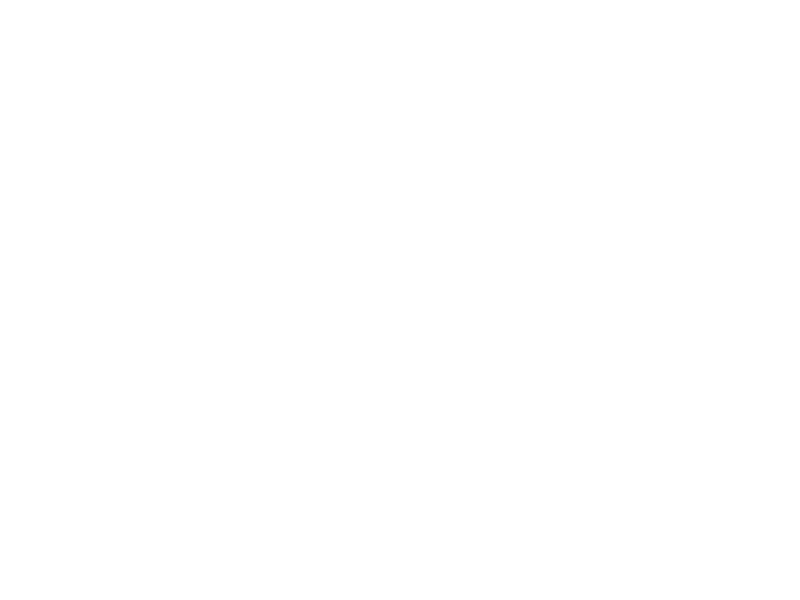

Po lewej:  50203
Po prawej:  49795
Współliniowe:  2


In [107]:
%matplotlib notebook
pr_points(points1,det1_3x3,a,b,tol,prec)

<IPython.core.display.Javascript object>


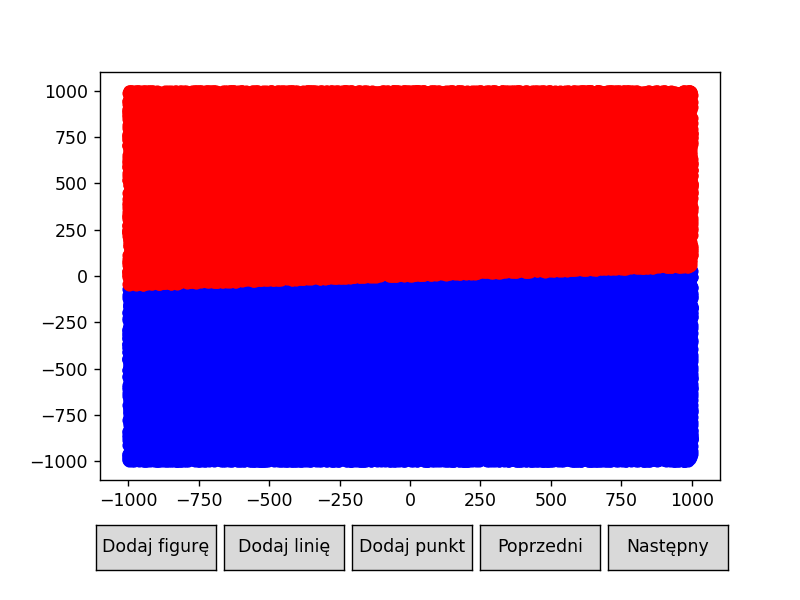

Po lewej:  50204
Po prawej:  49796
Współliniowe:  0


In [108]:
%matplotlib notebook
pr_points(points1,det1_2x2,a,b,tol,prec)

<IPython.core.display.Javascript object>


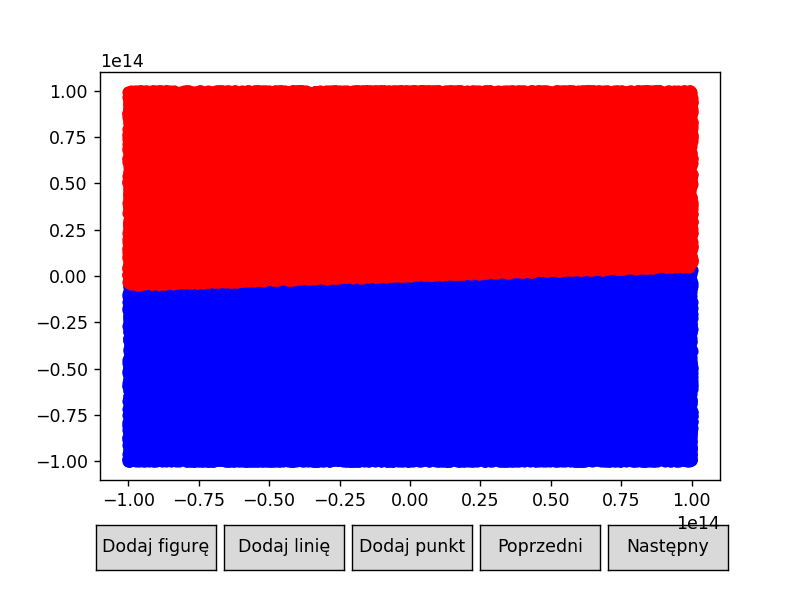

Po lewej:  50128
Po prawej:  49872
Współliniowe:  0


In [109]:
%matplotlib notebook
pr_points(points2,det1_3x3,a,b,tol,prec)

<IPython.core.display.Javascript object>


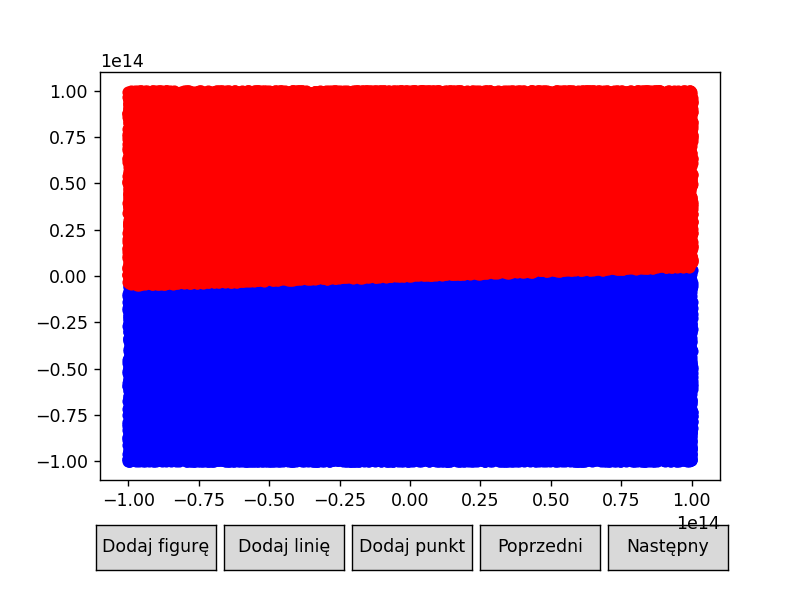

Po lewej:  50128
Po prawej:  49872
Współliniowe:  0


In [110]:
%matplotlib notebook
pr_points(points2,det1_2x2,a,b,tol,prec)

<IPython.core.display.Javascript object>


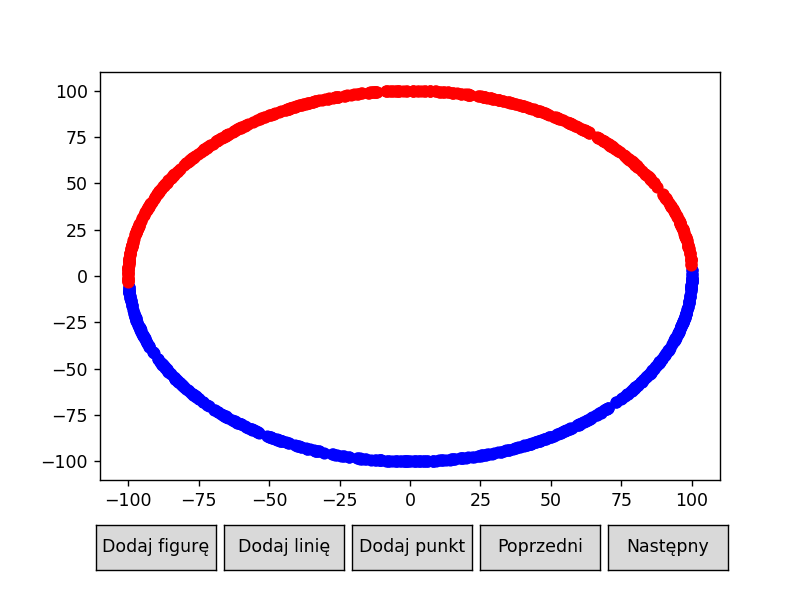

Po lewej:  495
Po prawej:  505
Współliniowe:  0


In [111]:
%matplotlib notebook
pr_points(points3,det1_3x3,a,b,tol,prec)

<IPython.core.display.Javascript object>


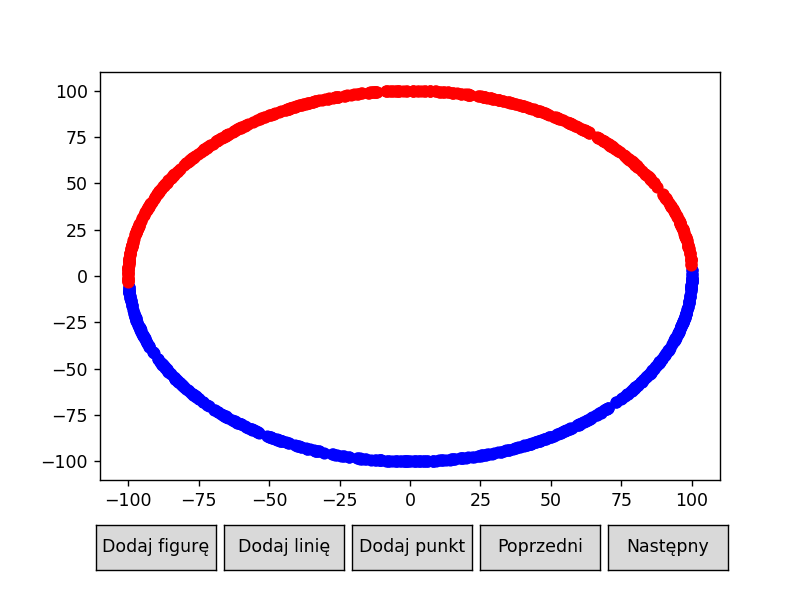

Po lewej:  495
Po prawej:  505
Współliniowe:  0


In [112]:
%matplotlib notebook
pr_points(points3,det1_2x2,a,b,tol,prec)

<IPython.core.display.Javascript object>


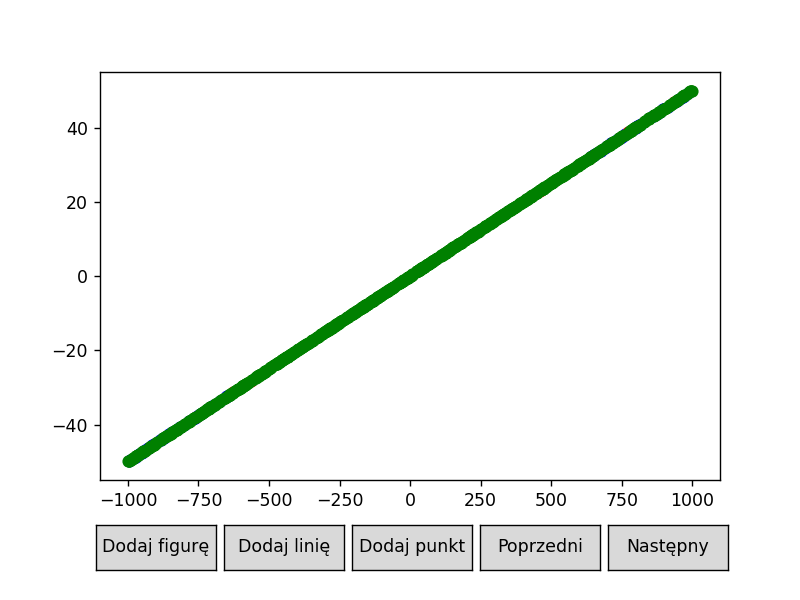

Po lewej:  94
Po prawej:  8
Współliniowe:  898


In [113]:
%matplotlib notebook
pr_points(points4,det1_3x3,a,b,tol,prec)

<IPython.core.display.Javascript object>


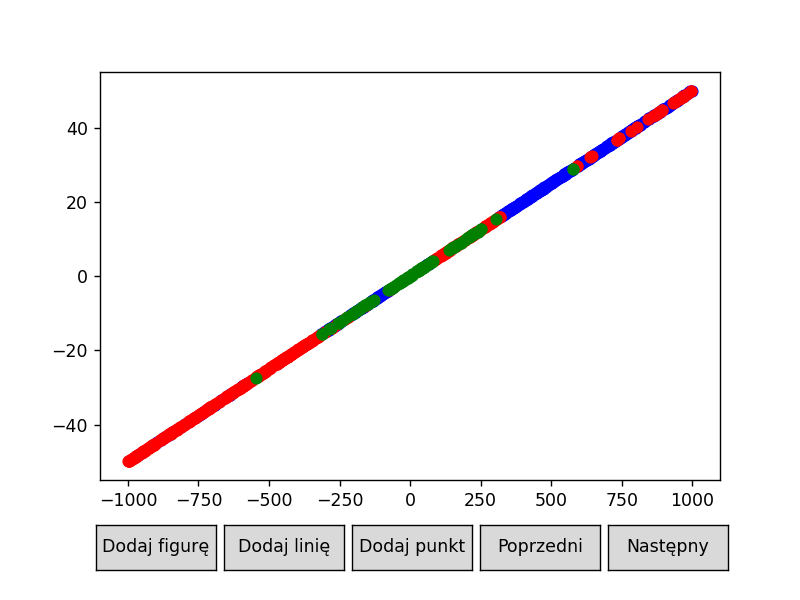

Po lewej:  447
Po prawej:  422
Współliniowe:  131


In [114]:
%matplotlib notebook
pr_points(points4,det1_2x2,a,b,tol,prec)

#### Porównanie klasyfikacji punktów dla różnych sposobów liczenia wyznacznika

In [115]:
def merge(cl):
    res = [[x,'l'] for x in cl['l']]
    res.extend([[x,'r'] for x in cl['r']])
    res.extend([[x,'c'] for x in cl['c']])
    return res

def diff(points, det1, det2,tolerance,precision):
    res1 = classify_points(points,det1,a,b,tolerance,precision)
    res1_merged = sorted(merge(res1))
    
    res2 = classify_points(points,det2,a,b,tolerance,precision)
    res2_merged = sorted(merge(res2))
    res=0
    for i in range(len(res1_merged)):
        if res1_merged[i][0] == res2_merged[i][0] and res1_merged[i][1]!=res2_merged[i][1]:
            res+=1
    return res

#### Badanie różnic dla zmiennej tolerancji dla 0

In [116]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points1,det3x3,det1_3x3,t,0))

1
1
1
1
0
0
0
0


In [117]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points1,det3x3,det2x2,t,0))

2
2
2
2
0
0
0
0


In [118]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points1,det2x2,det1_2x2,t,0))

2
2
2
2
2
2
1
0


In [119]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points1,det1_2x2,det1_3x3,t,0))

1
1
1
1
2
2
1
0


In [120]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points1,det1_2x2,det3x3,t,0))

0
0
0
0
2
2
1
0


In [121]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points1,det1_3x3,det2x2,t,0))

2
2
2
2
0
0
0
0


In [122]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points2,det3x3,det1_3x3,t,0))

0
0
0
0
0
0
0
0


In [123]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points2,det3x3,det2x2,t,0))

3
3
3
3
3
3
3
3


In [124]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points2,det2x2,det1_2x2,t,0))

3
3
3
3
3
3
3
3


In [125]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points2,det1_3x3,det1_2x2,t,0))

2
2
2
2
2
2
2
2


In [126]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points2,det1_2x2,det3x3,t,0))

2
2
2
2
2
2
2
2


In [127]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points2,det1_3x3,det2x2,t,0))

3
3
3
3
3
3
3
3


In [128]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points3,det3x3,det1_3x3,t,0))

0
0
0
0
0
0
0
0


In [129]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points3,det3x3,det2x2,t,0))

0
0
0
0
0
0
0
0


In [130]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points3,det2x2,det1_2x2,t,0))

0
0
0
0
0
0
0
0


In [131]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points3,det1_2x2,det1_3x3,t,0))

0
0
0
0
0
0
0
0


In [132]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points3,det3x3,det1_2x2,t,0))

0
0
0
0
0
0
0
0


In [133]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points3,det2x2,det1_3x3,t,0))

0
0
0
0
0
0
0
0


In [134]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points4,det3x3,det1_3x3,t,0))

554
552
545
444
102
0
0
0


In [135]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points4,det3x3,det2x2,t,0))

701
701
696
656
288
271
166
0


In [136]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points4,det2x2,det1_2x2,t,0))

708
708
709
691
634
553
295
0


In [137]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points4,det1_2x2,det1_3x3,t,0))

488
494
514
608
818
694
260
0


In [138]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points4,det1_2x2,det3x3,t,0))

689
689
690
689
869
694
260
0


In [139]:
for i in range (-18,-10,1):
    t=10**i
    print(diff(points4,det1_3x3,det2x2,t,0))

838
825
811
694
357
271
166
0


#### Badanie różnic dla zmiennej precyzji obliczeń

In [140]:
tol1=10**(-14)

In [141]:
for i in range (20,10,-1):
    p=i
    print(diff(points1,det3x3,det1_3x3,tol1,p))

0
0
0
0
0
0
0
0
0
0


In [142]:
for i in range (20,10,-1):
    p=i
    print(diff(points1,det3x3,det2x2,tol1,p))

0
0
0
0
0
0
0
0
0
0


In [143]:
for i in range (20,10,-1):
    p=i
    print(diff(points1,det2x2,det1_2x2,tol1,p))

2
2
2
2
2
2
2
2
2
0


In [144]:
for i in range (20,10,-1):
    p=i
    print(diff(points1,det1_2x2,det1_3x3,tol1,p))

2
2
2
2
2
2
2
2
2
0


In [145]:
for i in range (20,10,-1):
    p=i
    print(diff(points1,det3x3,det1_2x2,tol1,p))

2
2
2
2
2
2
2
2
2
0


In [146]:
for i in range (20,10,-1):
    p=i
    print(diff(points1,det1_3x3,det2x2,tol1,p))

0
0
0
0
0
0
0
0
0
0


In [147]:
for i in range (20,10,-1):
    p=i
    print(diff(points2,det3x3,det1_3x3,tol1,p))

0
0
0
0
0
0
0
0
0
0


In [148]:
for i in range (20,10,-1):
    p=i
    print(diff(points2,det3x3,det2x2,tol1,p))

3
3
3
3
3
3
3
3
3
3


In [149]:
for i in range (20,10,-1):
    p=i
    print(diff(points2,det1_2x2,det2x2,tol1,p))

3
3
3
3
3
3
3
3
3
3


In [150]:
for i in range (20,10,-1):
    p=i
    print(diff(points2,det1_3x3,det1_2x2,tol1,p))

2
2
2
2
2
2
2
2
2
2


In [151]:
for i in range (20,10,-1):
    p=i
    print(diff(points2,det1_3x3,det2x2,tol1,p))

3
3
3
3
3
3
3
3
3
3


In [152]:
for i in range (20,10,-1):
    p=i
    print(diff(points2,det3x3,det1_2x2,tol1,p))

2
2
2
2
2
2
2
2
2
2


In [153]:
for i in range (20,10,-1):
    p=i
    print(diff(points3,det3x3,det1_3x3,tol1,p))

0
0
0
0
0
0
0
0
0
0


In [154]:
for i in range (20,10,-1):
    p=i
    print(diff(points3,det3x3,det2x2,tol1,p))

0
0
0
0
0
0
0
0
0
0


In [155]:
for i in range (20,10,-1):
    p=i
    print(diff(points3,det2x2,det1_2x2,tol1,p))

0
0
0
0
0
0
0
0
0
0


In [156]:
for i in range (20,10,-1):
    p=i
    print(diff(points3,det1_2x2,det1_3x3,tol1,p))

0
0
0
0
0
0
0
0
0
0


In [157]:
for i in range (20,10,-1):
    p=i
    print(diff(points3,det3x3,det1_2x2,tol1,p))

0
0
0
0
0
0
0
0
0
0


In [158]:
for i in range (20,10,-1):
    p=i
    print(diff(points3,det2x2,det1_3x3,tol1,p))

0
0
0
0
0
0
0
0
0
0


In [159]:
for i in range (16,9,-1):
    p=i
    print(diff(points4,det3x3,det1_3x3,tol1,p))

102
93
35
0
0
0
0


In [160]:
for i in range (16,9,-1):
    p=i
    print(diff(points4,det3x3,det2x2,tol1,p))

288
288
285
284
216
27
0


In [161]:
for i in range (16,9,-1):
    p=i
    print(diff(points4,det2x2,det1_2x2,tol1,p))

634
634
622
586
412
27
0


In [162]:
for i in range (16,9,-1):
    p=i
    print(diff(points4,det1_2x2,det1_3x3,tol1,p))

818
821
844
792
480
0
0


In [163]:
for i in range (16,9,-1):
    p=i
    print(diff(points4,det3x3,det1_2x2,tol1,p))

869
869
858
792
480
0
0


In [164]:
for i in range (16,9,-1):
    p=i
    print(diff(points4,det2x2,det1_3x3,tol1,p))

357
349
306
284
216
27
0


#### Graficzne różnice w podziale punktów

In [165]:
def diff_points(points, det1, det2,tolerance,precision):
    res1 = classify_points(points,det1,a,b,tolerance,precision)
    res1_merged = sorted(merge(res1))
    
    res2 = classify_points(points,det2,a,b,tolerance,precision)
    res2_merged = sorted(merge(res2))
    res=[]
    for i in range(len(res1_merged)):
        if res1_merged[i][0] == res2_merged[i][0] and res1_merged[i][1]!=res2_merged[i][1]:
            res.append(res1_merged[i][0])
    return res


<IPython.core.display.Javascript object>


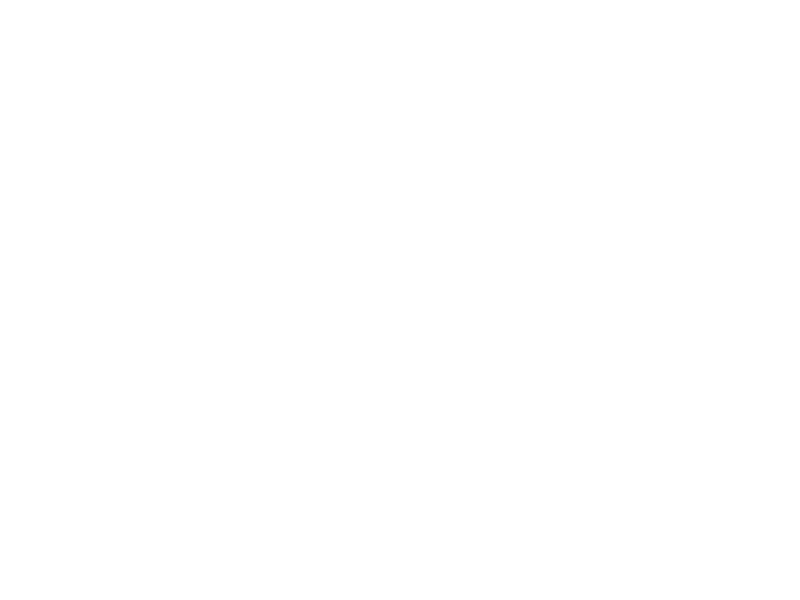

0  det3x3   det1_3x3 


In [166]:
%matplotlib notebook
lista=diff_points(points1,det3x3,det1_3x3,tol1,0)
plot=Plot(points=[PointsCollection(lista,color='red')])
plot.draw()
n=len(lista)
print(n," det3x3 "," det1_3x3 ")
for i in range (n):
    print(lista[i])
    print(det3x3(a,b,lista[i]),det1_3x3(a,b,lista[i]))

<IPython.core.display.Javascript object>


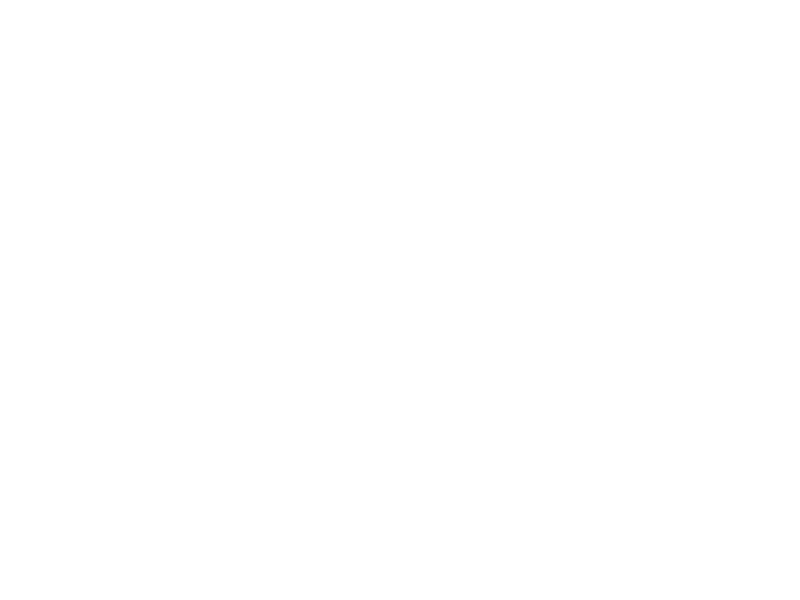

2  det1_2x2   det1_3x3 
(-761, -38)
2.2897905793684087e-12 1.8075773029048124e-15
(759, 38)
-8.437694987151169e-13 3.71411289953457e-15


In [167]:
%matplotlib notebook
lista=diff_points(points1,det1_2x2,det1_3x3,tol1,0)
plot=Plot(points=[PointsCollection(lista,color='red')])
plot.draw()
n=len(lista)
print(n," det1_2x2 "," det1_3x3 ")
for i in range (n):
    print(lista[i])
    print(det1_2x2(a,b,lista[i]),det1_3x3(a,b,lista[i]))

<IPython.core.display.Javascript object>


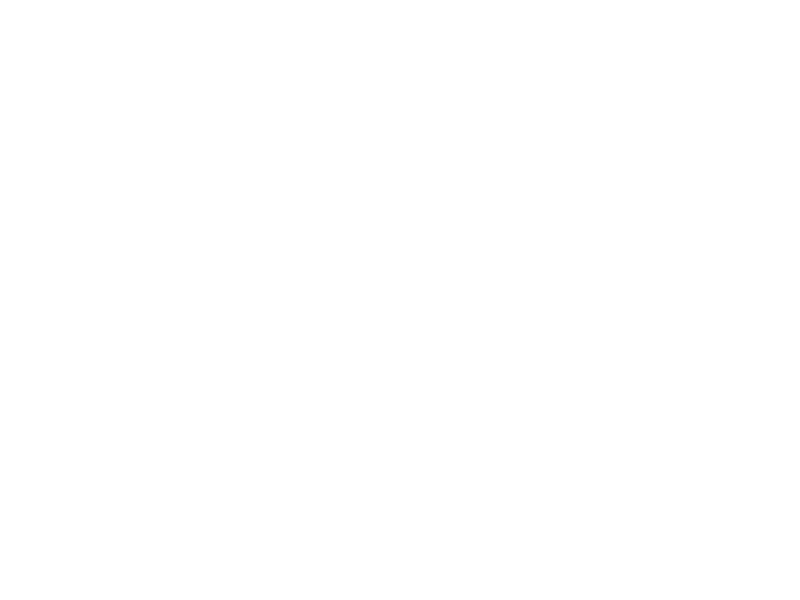

3  det3x3   det2x2 
(-77901460940049, -3897124070224)
-4102046443.199707 0.0
(39573964230919, 1981107991682)
4819560271.999512 0.0
(83874154916170, 4210921182097)
34426872576.8999 0.0


In [168]:
%matplotlib notebook
lista=diff_points(points2,det3x3,det2x2,tol1,0)
plot=Plot(points=[PointsCollection(lista,color='red')])
plot.draw()
n=len(lista)
print(n," det3x3 ", " det2x2 ")
for i in range (n):
    print(lista[i])
    print(det3x3(a,b,lista[i]),det2x2(a,b,lista[i]))

<IPython.core.display.Javascript object>


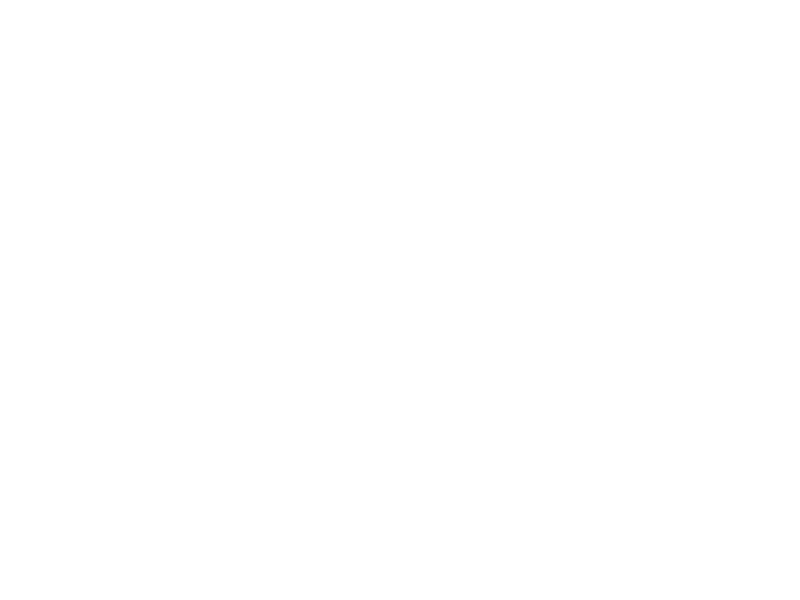

3  det1_2x2   det2x2 
(-77901460940049, -3897124070224)
11795877645.618303 0.0
(39573964230919, 1981107991682)
-858501676.8795046 0.0
(83874154916170, 4210921182097)
34905844295.66491 0.0


In [169]:
%matplotlib notebook
lista=diff_points(points2,det1_2x2,det2x2,tol1,0)
plot=Plot(points=[PointsCollection(lista,color='red')])
plot.draw()
n=len(lista)
print(n," det1_2x2 "," det2x2 ")
for i in range (n):
    print(lista[i])
    print(det1_2x2(a,b,lista[i]),det2x2(a,b,lista[i]))

<IPython.core.display.Javascript object>


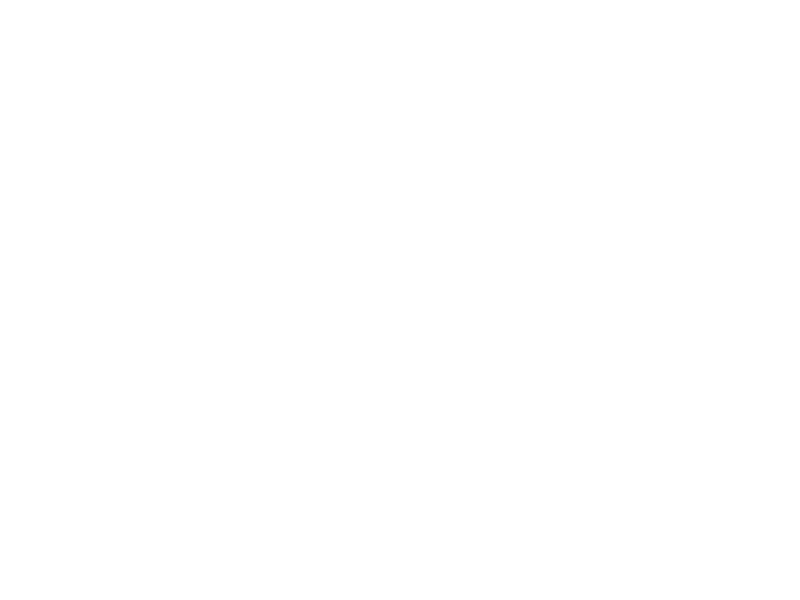

2  det1_2x2   det1_3x3 
(-77901460940049, -3897124070224)
11795877645.618303 -4102046443.199768
(39573964230919, 1981107991682)
-858501676.8795046 4819560271.999828


In [170]:
%matplotlib notebook
lista=diff_points(points2,det1_2x2,det1_3x3,tol1,0)
plot=Plot(points=[PointsCollection(lista,color='red')])
plot.draw()
n=len(lista)
print(n," det1_2x2 "," det1_3x3 ")
for i in range (n):
    print(lista[i])
    print(det1_2x2(a,b,lista[i]),det1_3x3(a,b,lista[i]))

<IPython.core.display.Javascript object>


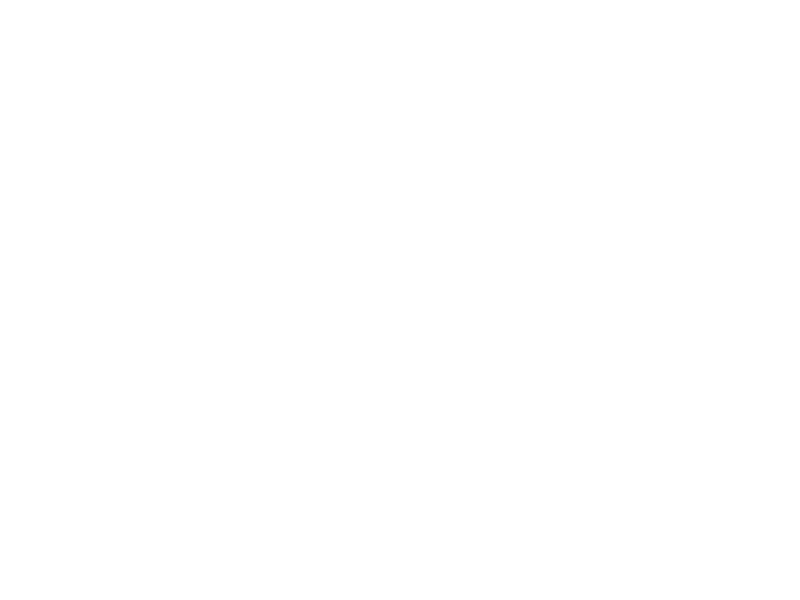

102


In [171]:
%matplotlib notebook
lista=diff_points(points4,det3x3,det1_3x3,tol1,0)
plot=Plot(points=[PointsCollection(lista,color='green')])
plot.draw()
n=len(lista)
print(n)

<IPython.core.display.Javascript object>


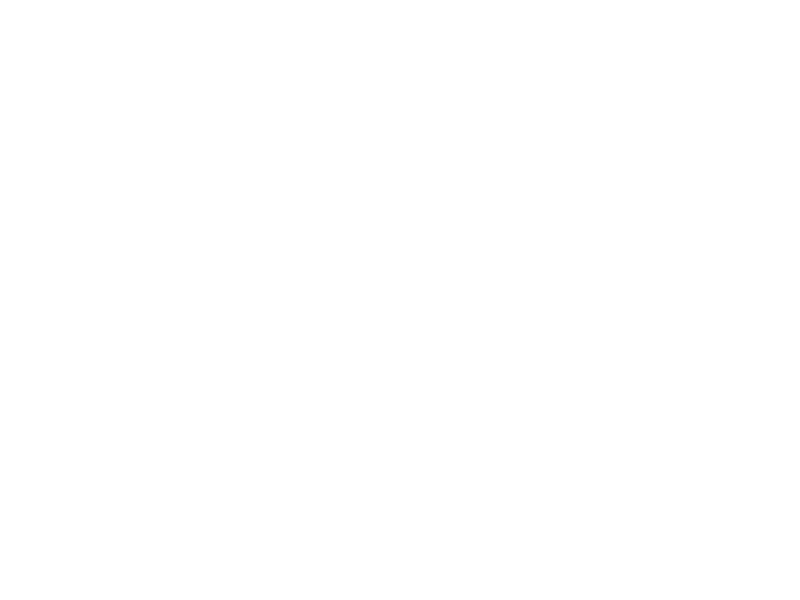

27


In [172]:
%matplotlib notebook
lista=diff_points(points4,det3x3,det2x2,tol1,11)
plot=Plot(points=[PointsCollection(lista,color='red')])
plot.draw()
n=len(lista)
print(n)

<IPython.core.display.Javascript object>


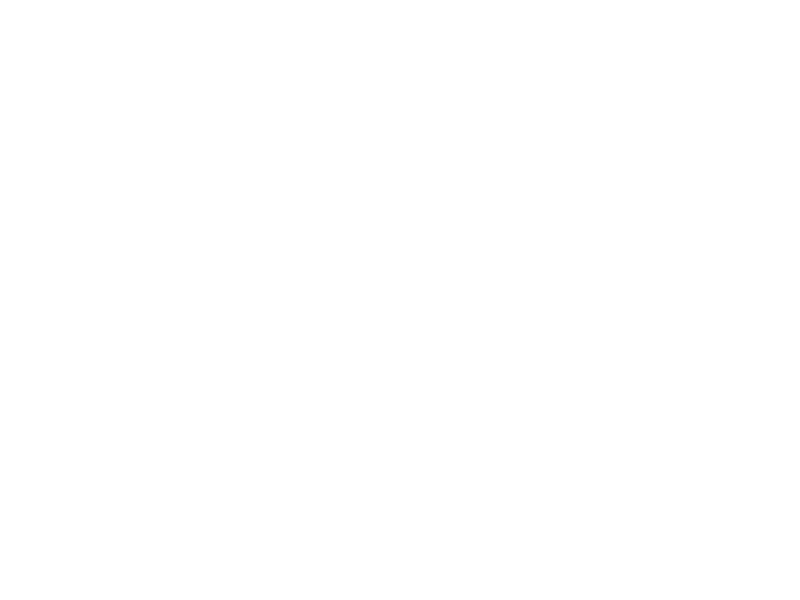

27


In [173]:
%matplotlib notebook
lista=diff_points(points4,det2x2,det1_2x2,tol1,11)
plot=Plot(points=[PointsCollection(lista,color='green')])
plot.draw()
n=len(lista)
print(n)

<IPython.core.display.Javascript object>


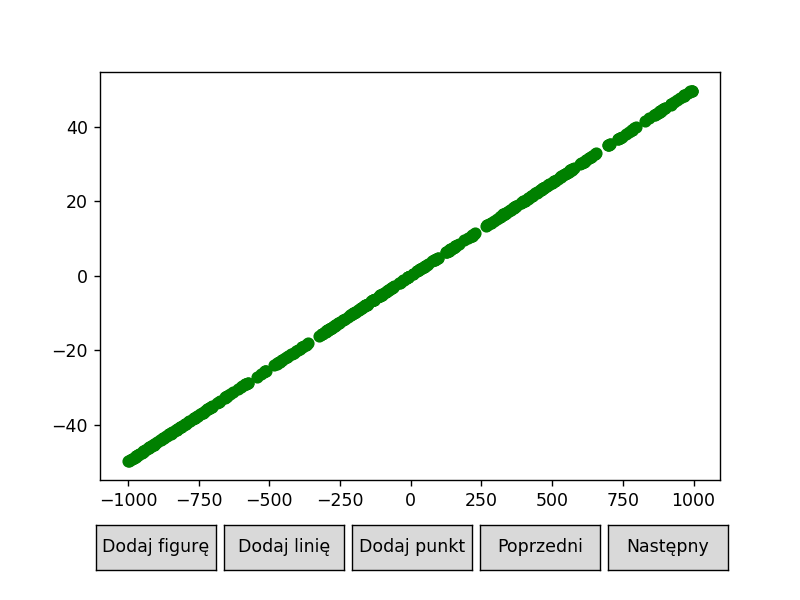

488


In [174]:
%matplotlib notebook
lista=diff_points(points4,det1_2x2,det1_3x3,(10**(-18)),0)
plot=Plot(points=[PointsCollection(lista,color='green')])
plot.draw()
n=len(lista)
print(n)